In [1]:
!pip install seaborn

In [4]:
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as sk_cluster

In [5]:
data_sp = sparse.load_npz('train.npz')

In [8]:
data_sp.count_nonzero() / (data_sp.shape[0] * data_sp.shape[1])

0.18280030923487794

In [7]:
def safe_pred(pred, filename):
    submission = pd.read_csv('sample_submission.csv', index_col='ID')
    submission['TARGET'] = pred
    submission.to_csv(filename)

Заполнено только 18,3%.

Гипотеза №1: можно без особой потери перейти в пространство размерности в 5 раз меньше, т.е.

In [14]:
int(data_sp.shape[1] * 0.2)

609

Попробуем спроецировать всё на двумерную плоскость, чтобы можно было посмотреть на данные.

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=72)
data_sp_2d = pca.fit_transform(data_sp)

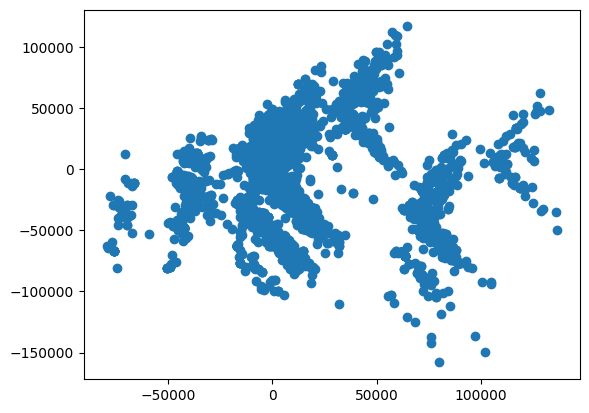

In [7]:
plt.scatter(data_sp_2d[:, 0], data_sp_2d[:, 1])
plt.show()

Проглядываются бумерангообразные классы.

### Попробуем применить обычный k-means

In [8]:
from sklearn.cluster import KMeans

In [12]:
kmeans = KMeans(n_clusters=8, random_state=34)
pred_kmeans = kmeans.fit_predict(data_sp_2d)


<Axes: >

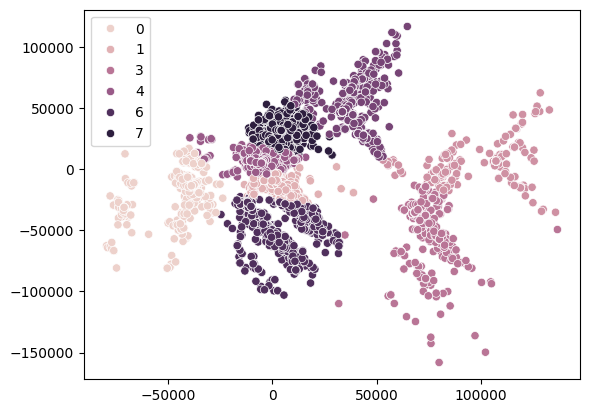

In [13]:
sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_kmeans)

Попробуем взять его в качестве baseline.

In [16]:
safe_pred(pred_kmeans, 'submission_kmeans.csv')

Score: 0.05598

Поэкспериментируем с алгоритмами.

<Axes: >

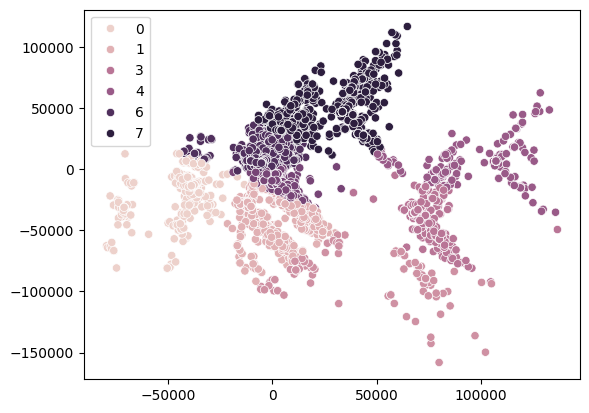

In [43]:
bi_kmeans = sk_cluster.BisectingKMeans(n_clusters=8, random_state=34)
pred_bikmeans = bi_kmeans.fit_predict(data_sp_2d)
sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_bikmeans)

Не то. Попробуем спектральную кластеризацию.

Почему-то падает ядро. Кажется, n_clusters должно быть не больше размерности данных. Ладно, пойдем дальше.

## Spectral Clustering

### Просто Spectral Clustering

In [6]:
# spectral = sk_cluster.SpectralClustering(n_clusters=8, random_state=34, n_jobs=10, verbose=True)
# pred_spectral = spectral.fit_predict(data_sp)

: 

Ядро упало. Не смог дождаться результата.

### PCA + Spectral Clustering

In [ ]:
# pca = PCA(n_components=600, random_state=72)
# data_sp_600d = pca.fit_transform(data_sp)

In [ ]:
# spectral = sk_cluster.SpectralClustering(n_clusters=8, random_state=34, n_jobs=10, verbose=True)
# pred_spectral = spectral.fit_predict(data_sp_600d)

: 

Нужно очень много ОЗУ. 10 ГБ не хватает. Попробуем ещё сократить размерность.

In [ ]:
# pca = PCA(n_components=10, random_state=72)
# data_sp_10d = pca.fit_transform(data_sp)

In [ ]:
# spectral = sk_cluster.SpectralClustering(n_clusters=8, random_state=34, verbose=True)
# pred_spectral = spectral.fit_predict(data_sp_10d)

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


: 

Всё ещё не работает. Сжирает всю ОЗУ.

## Birch

### Просто Birch

In [ ]:
# birch = sk_cluster.Birch(n_clusters=8)
# pred_birch = birch.fit_predict(data_sp)

Очень долго считает.

### PCA + Birch

In [5]:
pca = PCA(n_components=600, random_state=72)
data_sp_600d = pca.fit_transform(data_sp)

In [6]:
birch = sk_cluster.Birch(n_clusters=8)
pred_birch = birch.fit_predict(data_sp_600d)

Визуализируем результат.

<Axes: >

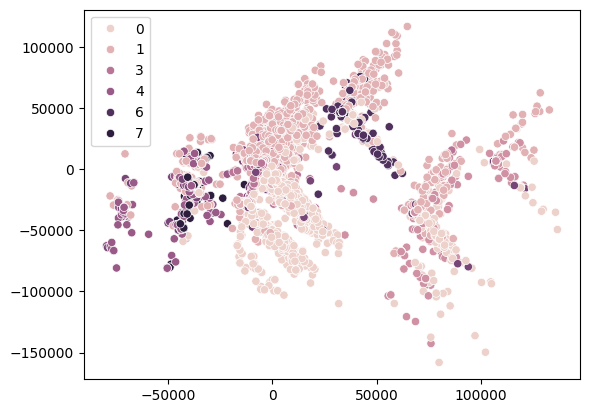

In [7]:
sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_birch)

In [8]:
safe_pred(pred_birch, 'submission_birch.csv')

Score: 0.09818 (почти достигли simple)

## Анализируем данные

In [17]:
data_sp.count_nonzero()

11704521

[]

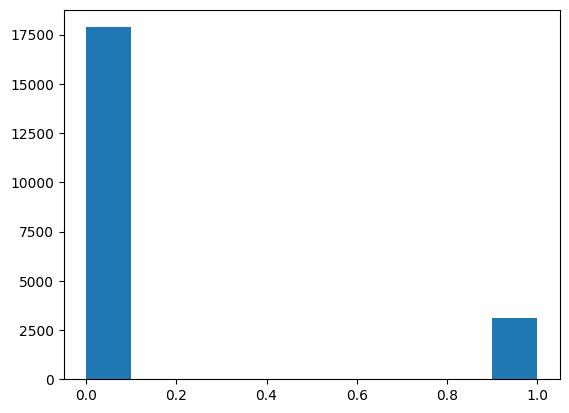

In [20]:
plt.hist(data_sp[:, 2].todense())
plt.plot()

In [22]:
data_sp[:, 2].sum()

np.float64(3127.0)

In [23]:
data_sp[:, 2].count_nonzero()

3127

Второй признак бинарный.

/tmp/ipykernel_63191/3278755364.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


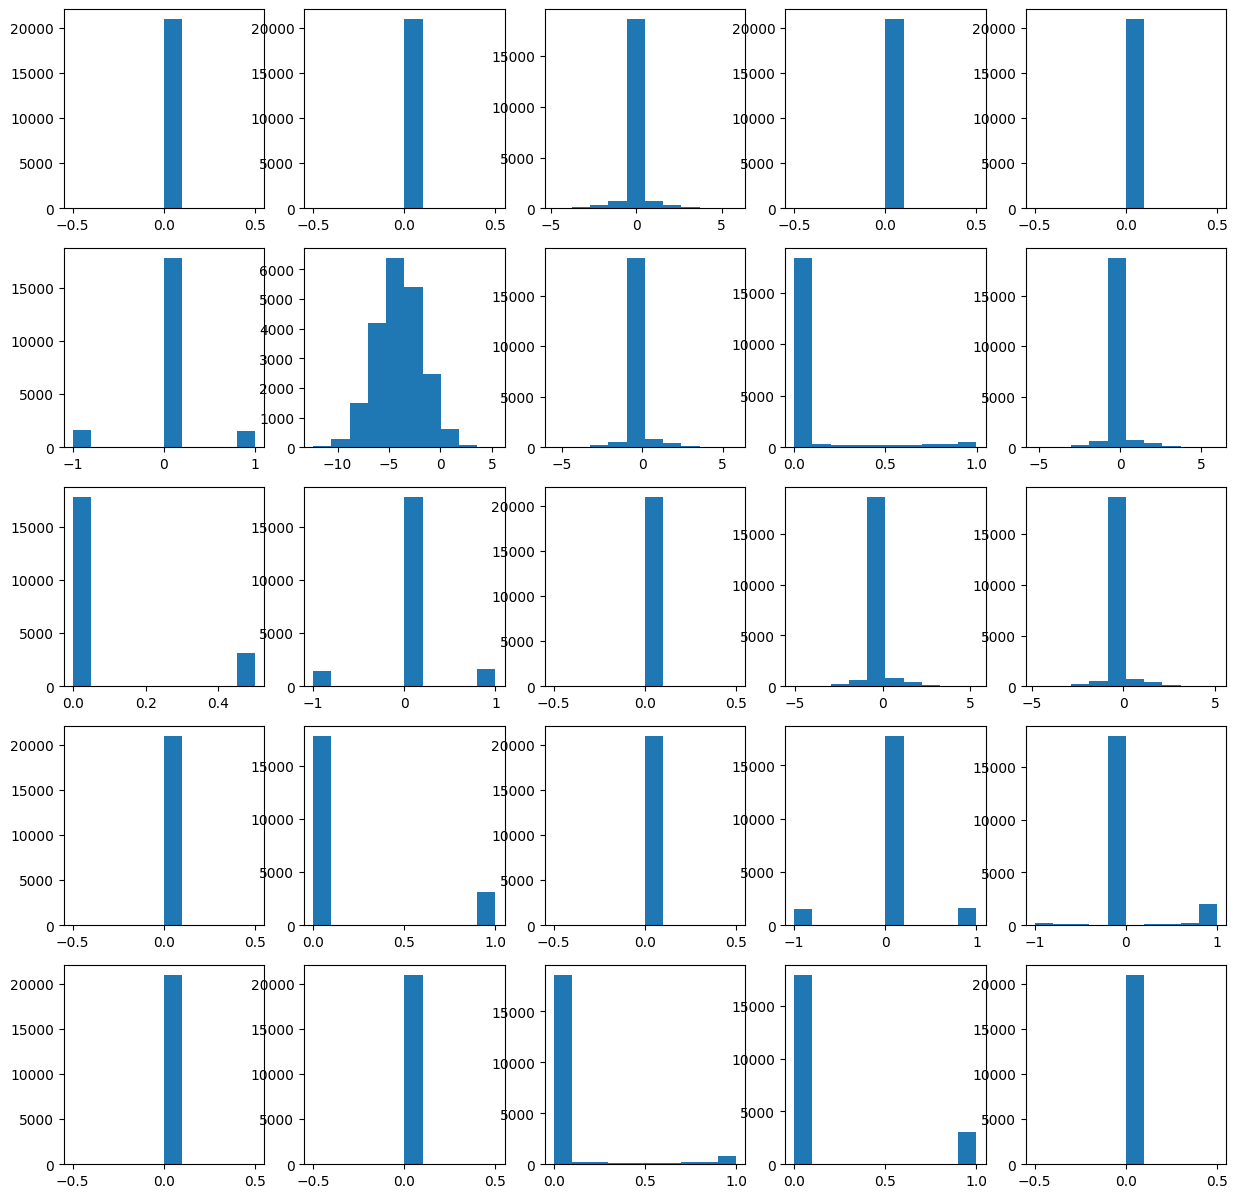

In [10]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()
start_ind = 3
count = 25
for i in range(count):
    axes[i].hist(data_sp[:, i + start_ind].todense())
fig.show()

Очень много константных признаков. Найдем их все.

In [11]:
const_features = []
for i in range(data_sp.shape[1]):
    column_data = np.array(data_sp[:, i].todense())[:, 0]
    uniq = np.unique(column_data)
    count_uniq = len(uniq)
    if count_uniq == 1:
        const_features.append(i)

In [12]:
len(const_features)

616

In [13]:
len(const_features) / data_sp.shape[1]

0.20203345359134142

Т.е. 20% данных можно спокойно удалить.

А теперь сгруппируем по количеству.

In [9]:
from collections import defaultdict

In [10]:
feat_uniq_count = defaultdict(list)
for i in range(data_sp.shape[1]):
    column_data = np.array(data_sp[:, i].todense())[:, 0]
    uniq = np.unique(column_data)
    count_uniq = len(uniq)
    feat_uniq_count[count_uniq].append(i)

In [16]:
len(feat_uniq_count[2])

405

Также много бинарных признаков.

In [128]:
str(sorted(feat_uniq_count[1]))

'[3, 4, 6, 7, 15, 18, 20, 23, 24, 27, 29, 32, 37, 48, 49, 50, 51, 63, 68, 70, 72, 75, 86, 87, 90, 100, 104, 106, 116, 131, 139, 140, 144, 145, 147, 149, 153, 160, 181, 182, 193, 209, 216, 224, 229, 235, 241, 251, 253, 254, 255, 256, 257, 259, 264, 266, 281, 282, 287, 289, 290, 294, 298, 315, 317, 318, 320, 326, 330, 334, 337, 339, 341, 347, 361, 374, 381, 386, 401, 404, 415, 418, 421, 425, 435, 437, 439, 447, 470, 471, 473, 486, 489, 490, 492, 493, 500, 504, 507, 510, 512, 515, 517, 522, 527, 532, 533, 541, 543, 553, 554, 556, 566, 573, 579, 581, 584, 587, 589, 592, 598, 600, 602, 610, 611, 621, 622, 623, 628, 629, 636, 643, 646, 654, 657, 659, 661, 663, 670, 674, 676, 677, 680, 682, 688, 694, 699, 703, 714, 723, 724, 733, 739, 744, 748, 751, 752, 763, 765, 768, 772, 774, 775, 776, 778, 780, 791, 795, 798, 806, 811, 819, 821, 828, 829, 831, 839, 840, 841, 851, 853, 855, 858, 861, 868, 872, 877, 881, 882, 885, 887, 888, 892, 914, 916, 917, 924, 925, 943, 945, 950, 957, 960, 962, 963, 96

In [129]:
str(feat_uniq_count[21000])

'[9, 64, 74, 80, 96, 97, 99, 110, 111, 130, 152, 156, 159, 187, 198, 206, 226, 246, 258, 260, 276, 279, 295, 306, 316, 321, 345, 365, 373, 377, 395, 402, 414, 422, 432, 444, 462, 463, 474, 491, 505, 514, 546, 547, 571, 582, 591, 596, 597, 607, 608, 615, 655, 662, 692, 697, 719, 726, 729, 732, 736, 745, 779, 808, 830, 844, 847, 857, 862, 869, 878, 899, 913, 929, 939, 958, 977, 1008, 1049, 1053, 1102, 1106, 1109, 1111, 1145, 1146, 1158, 1169, 1242, 1252, 1254, 1255, 1270, 1272, 1298, 1299, 1306, 1308, 1330, 1340, 1343, 1361, 1387, 1393, 1397, 1404, 1416, 1455, 1462, 1467, 1477, 1493, 1508, 1521, 1556, 1605, 1607, 1627, 1637, 1659, 1666, 1686, 1701, 1744, 1753, 1759, 1761, 1766, 1772, 1783, 1799, 1825, 1841, 1842, 1843, 1848, 1896, 1901, 1910, 1922, 1924, 1928, 1940, 1962, 1970, 1975, 1979, 1980, 1993, 2028, 2029, 2033, 2062, 2065, 2074, 2078, 2079, 2089, 2099, 2105, 2114, 2115, 2120, 2129, 2132, 2136, 2150, 2155, 2164, 2174, 2197, 2199, 2202, 2206, 2218, 2219, 2240, 2261, 2272, 2320, 232

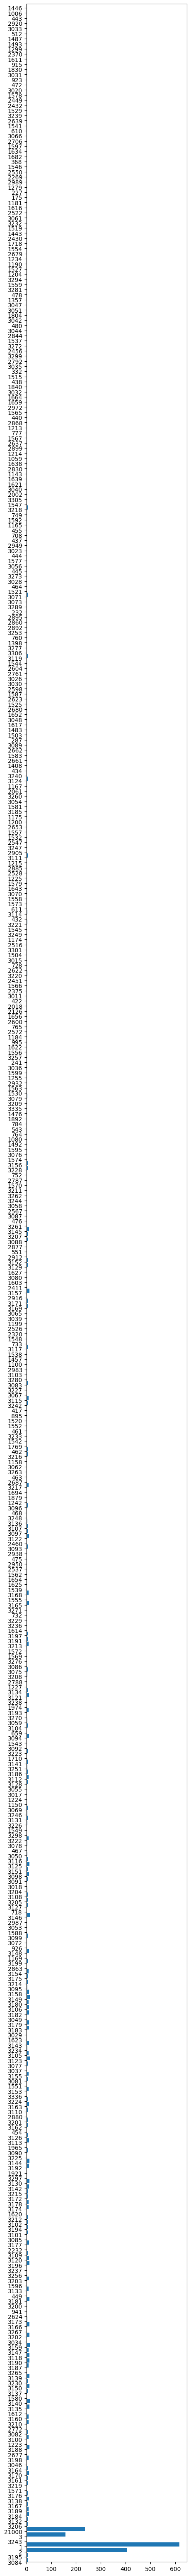

In [101]:
f, ax = plt.subplots(figsize=(5, 80))
ax.margins(y=0)
plt.barh(list(map(str, feat_uniq_count.keys())), list(map(len, feat_uniq_count.values())), align='edge')
plt.show()

In [17]:
column_data = np.array(data_sp[:, 9].todense())[:, 0]
uniq = np.unique(column_data)
len(uniq)

21000

In [132]:
data_sp[:, 9].todense()

matrix([[-2.76893259],
        [-3.88885955],
        [-4.9337627 ],
        ...,
        [-1.03090927],
        [-5.78911538],
        [-4.75914258]], shape=(21000, 1))

In [127]:
(len(feat_uniq_count[1]) + len(feat_uniq_count[2])) / data_sp.shape[1]

0.3348638897999344

Треть всех признаков константные или бинарные.

In [ ]:
len(feat_uniq_count[4])

0

In [73]:
(len(feat_uniq_count[1]) + len(feat_uniq_count[2]) + len(feat_uniq_count[3]) ) / data_sp.shape[1]

0.38635618235487046

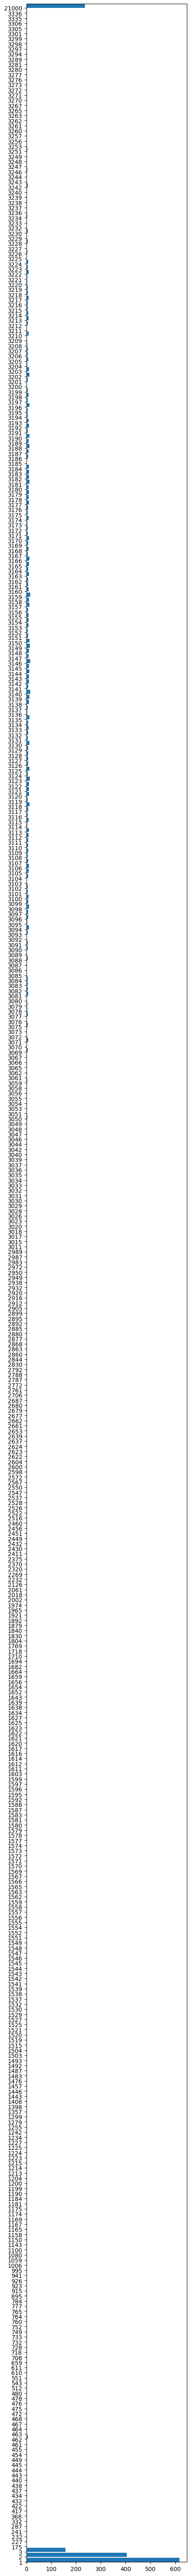

In [ ]:
counts = list(map(lambda i: (i[0], len(i[1])), feat_uniq_count.items()))
counts.sort(key=lambda i: i[0])
counts = np.array(counts)
f, ax = plt.subplots(figsize=(5, 80))
ax.margins(y=0)
plt.barh(list(map(str, counts[:, 0])), counts[:, 1], align='edge', )
plt.show()

In [86]:
feat_uniq_count[175]

[2586]

In [101]:
list(np.asarray(data_sp[:, 2586].todense())[:, 0])

[np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float6

Встречаются почти нулевые значения (4.767583445715402e-92).

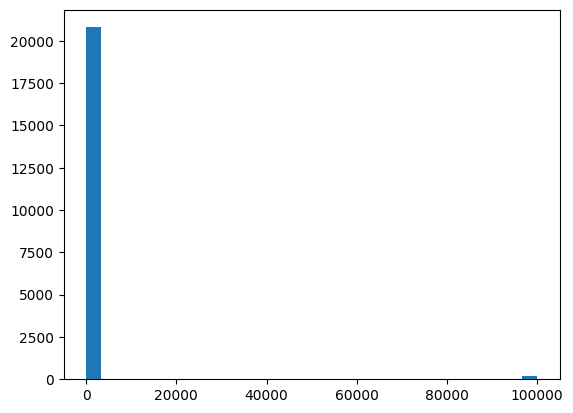

In [104]:
plt.hist(np.asarray(data_sp[:, 2586].todense())[:, 0], bins=30)
plt.show()

In [107]:
(np.abs(data_sp) < 1e-8).sum()

/tmp/ipykernel_63191/3023819922.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  (np.abs(data_sp) < 1e-8).sum()


np.int64(52354505)

In [108]:
52354505 / (data_sp.shape[0] * data_sp.shape[1])

0.8176686345249808

In [29]:
(np.abs(data_sp) < 1e-5).sum()

/tmp/ipykernel_65957/1929444565.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  (np.abs(data_sp) < 1e-5).sum()


np.int64(52369113)

In [30]:
52369113 / (data_sp.shape[0] * data_sp.shape[1])

0.8178967811460433

Нулей более 80%!

In [111]:
(data_sp >= -1e-20).sum()

/tmp/ipykernel_63191/906856809.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar less than zero using >= is inefficient, try using < instead.
  (data_sp >= -1e-20).sum()


np.int64(58691030)

In [112]:
58691030 / (data_sp.shape[0] * data_sp.shape[1])

0.9166319948773212

In [19]:
len(feat_uniq_count[1])

616

In [20]:
(np.array((np.abs(data_sp) <= 1e-8).sum(axis=0))[0] == 21000).sum()

/tmp/ipykernel_65957/3209725586.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using <= is inefficient, try using > instead.
  (np.array((np.abs(data_sp) <= 1e-8).sum(axis=0))[0] == 21000).sum()


np.int64(616)

Т.е. там, где есть такие маленькие, но не равные нулю, числа, там есть и что-то большое.

In [21]:
(data_sp < 0).sum()

np.int64(5337970)

In [22]:
5337970 / (data_sp.shape[0] * data_sp.shape[1])

0.08336800512267879

In [35]:
data_sp[np.abs(data_sp) < 1e-5] = 0.0

/tmp/ipykernel_65957/1997543055.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  data_sp[np.abs(data_sp) < 1e-5] = 0.0


In [36]:
data_sp.count_nonzero()

11659887

In [39]:
11659887 / data_sp.size

0.1821032188539568

Пересчитаем.

In [40]:
feat_uniq_count = defaultdict(list)
for i in range(data_sp.shape[1]):
    column_data = np.array(data_sp[:, i].todense())[:, 0]
    uniq = np.unique(column_data)
    count_uniq = len(uniq)
    feat_uniq_count[count_uniq].append(i)

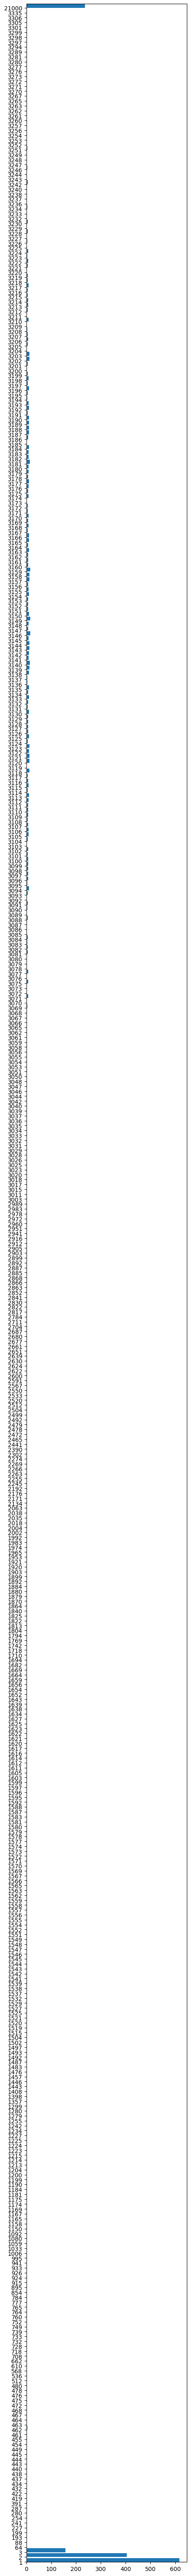

In [41]:
counts = list(map(lambda i: (i[0], len(i[1])), feat_uniq_count.items()))
counts.sort(key=lambda i: i[0])
counts = np.array(counts)
f, ax = plt.subplots(figsize=(5, 80))
ax.margins(y=0)
plt.barh(list(map(str, counts[:, 0])), counts[:, 1], align='edge', )
plt.show()

In [43]:
feat_uniq_count[64]

[2586]

(array([2.000e+00, 3.000e+01, 1.000e+00, 1.500e+01, 3.500e+01, 1.150e+02,
        2.756e+03, 6.300e+01, 2.100e+01, 6.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-18.39297814, -15.44661657, -12.50025501,  -9.55389344,
         -6.60753188,  -3.66117032,  -0.71480875,   2.23155281,
          5.17791437,   8.12427594,  11.0706375 ,  14.01699906,
         16.96336063,  19.90972219,  22.85608375,  25.80244532,
         28.74880688,  31.69516845,  34.64153001,  37.58789157,
         40.53425314,  43.4806147 ,  46.42697626,  49.37333783,
         52.31969939,  55.26606095,  58.21242252,  61.15878408,
         64.10514564,  67.05150721,  69.99786877]),
 <BarContainer object of 30 artists>)

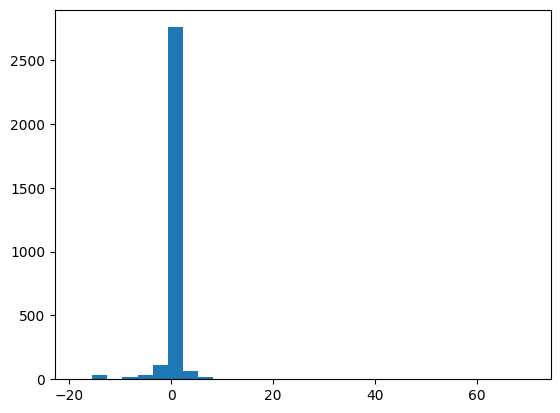

In [53]:
plt.hist(np.array(data_sp[2586, :].todense())[0], bins=30)

Как будто бы всё из одного распределения.

In [54]:
feat_uniq_count[88]

[1788]

(0.0, 100.0)

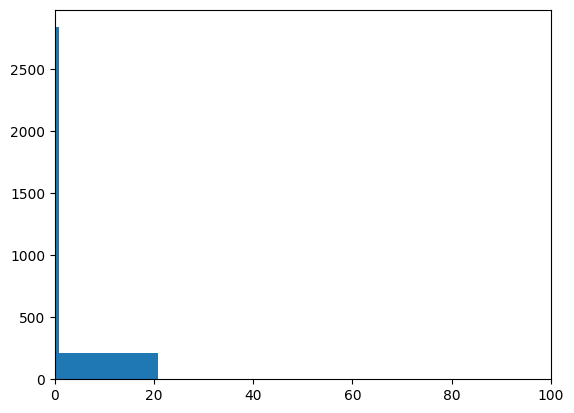

In [60]:
plt.hist(np.array(data_sp[1788, :].todense())[0], bins=5000)
plt.xlim([0, 100])

In [42]:
data_sp.shape

(21000, 3049)

In [18]:
def inv_ind(len, ind) -> np.ndarray:
    res = np.arange(len)
    res = res[~np.isin(res, ind)]
    return res

In [19]:
data_sp_clean = data_sp[:, inv_ind(data_sp.shape[1], feat_uniq_count[1])]

## Brich

In [136]:
pca = PCA(n_components=600, random_state=72)
data_sp_clean_600d = pca.fit_transform(data_sp_clean)

In [137]:
birch_clean = sk_cluster.Birch(n_clusters=8)
pred_birch_clean = birch_clean.fit_predict(data_sp_clean_600d)

Визуализируем результат.

<Axes: >

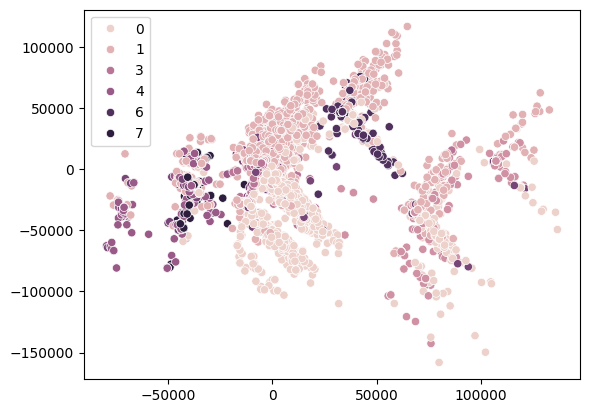

In [138]:
sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_birch_clean)

Сравним результаты:

<Axes: >

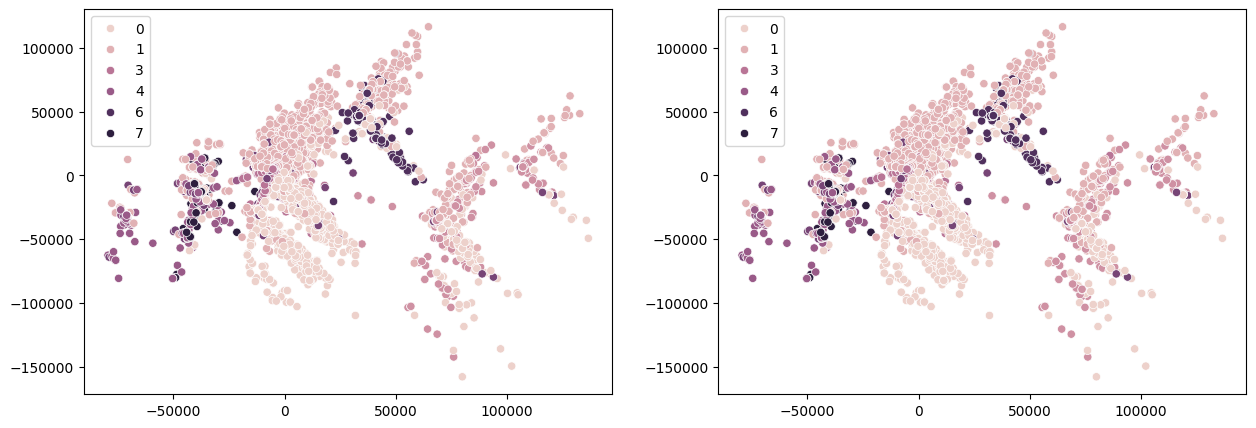

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_birch_clean, ax=ax1)
sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_birch, ax=ax2)

Ничего не поменялось (что и логично).

## Gaussian Mixture

In [144]:
from sklearn.mixture import GaussianMixture

In [147]:
gaus = GaussianMixture(n_components=8)
pred_gaus = gaus.fit_predict(data_sp_clean.toarray())

<Axes: >

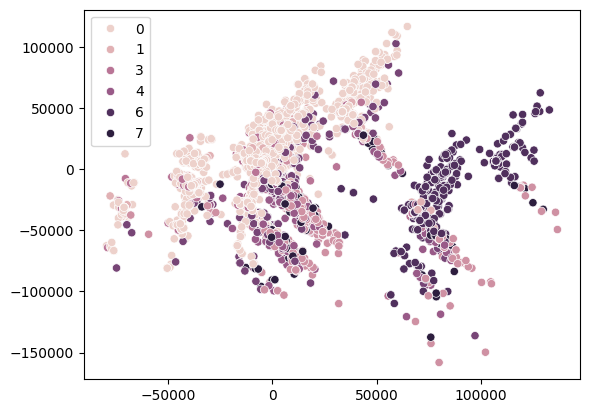

In [150]:
sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_gaus)

Выглядит логично.

In [149]:
safe_pred(pred_gaus, 'submission_gaus.csv')

Score: 0.04181

### PCA + Gaussian Mixture

In [151]:
gaus = GaussianMixture(n_components=8)
pred_gaus_600d = gaus.fit_predict(data_sp_600d)

<Axes: >

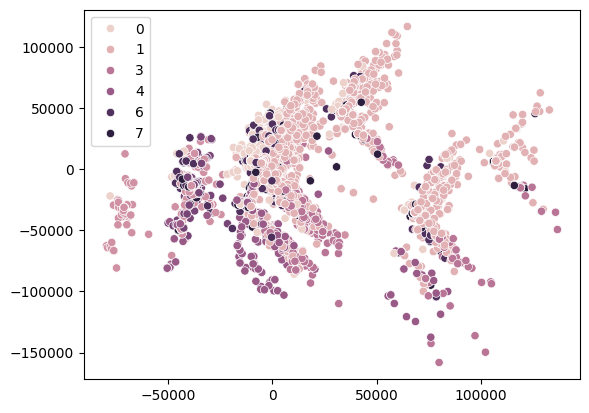

In [152]:
sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_gaus_600d)

Поиграемся с n_components.

1/4
2/4
3/4
4/4


/tmp/ipykernel_24468/2431242669.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


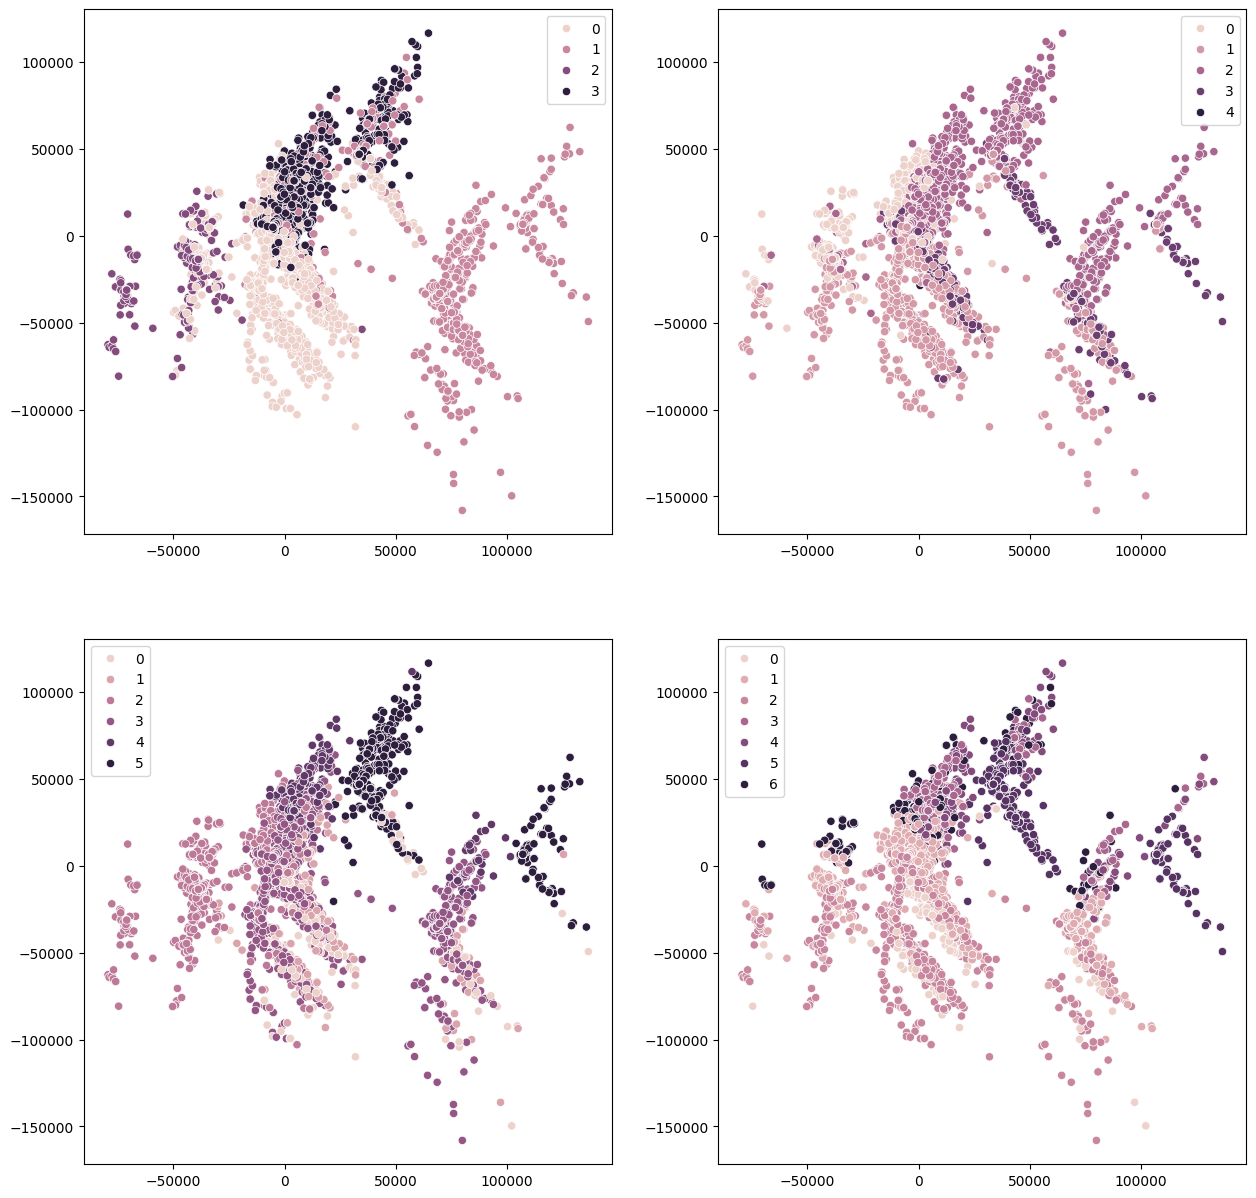

In [155]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()
start_component = 4
count = 2*2
for i in range(count):
    print(f"{i + 1}/{count}")
    gaus = GaussianMixture(n_components=i+start_component)
    pred_gaus_600d = gaus.fit_predict(data_sp_600d)
    sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_gaus_600d, ax=axes[i])
fig.show()

## HDBSCAN

### PCA + HDBSCAN

In [162]:
pca = PCA(n_components=10)
data_sp_10d = pca.fit_transform(data_sp_clean)

<Axes: >

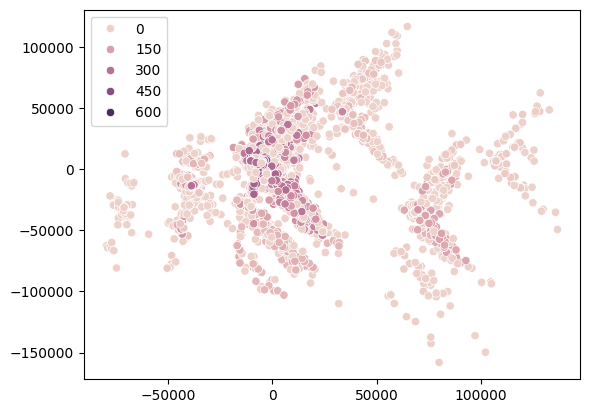

In [163]:
hdbscan = sk_cluster.HDBSCAN(min_cluster_size=5)
# hdbscan = sk_cluster.DBSCAN(min_samples=5)
pred_hdbscan = hdbscan.fit_predict(data_sp_10d)
sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_hdbscan)

In [164]:
pred_hdbscan

array([542,  -1, 370, ..., 210,  -1,  44], shape=(21000,))

# Пробуем нормализацию

In [20]:
from sklearn.preprocessing import RobustScaler

In [21]:
scaler = RobustScaler()

In [28]:
data_sp_clean.count_nonzero()

11704521

In [29]:
data_sp_clean.count_nonzero() / (data_sp_clean.shape[0] * data_sp_clean.shape[1]) 

0.22908267277317831

In [33]:
data_sp_clean_normal = scaler.fit_transform(np.asarray(data_sp_clean.todense()))

## Снова Birch

In [35]:
pca = PCA(n_components=600, random_state=72)
data_sp_clean_normal_600d = pca.fit_transform(data_sp_clean_normal)

In [36]:
birch_clean = sk_cluster.Birch(n_clusters=8)
pred_birch_clean = birch_clean.fit_predict(data_sp_clean_normal_600d)

<Axes: >

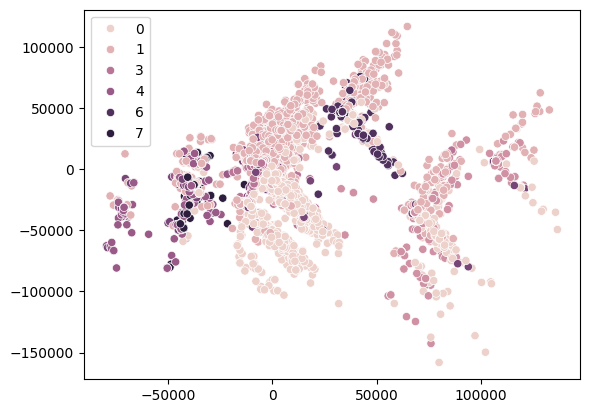

In [38]:
sns.scatterplot(x=data_sp_2d[:, 0], y=data_sp_2d[:, 1], hue=pred_birch_clean)

In [39]:
safe_pred(pred_birch_clean, 'submission_birch_normal.csv')

Score: 0.09818

## Теперь с UMAP

In [40]:
!pip install umap-learn

  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 9.5 MB/s eta 0:00:00ta 0:00:01
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 8.4 MB/s eta 0:00:0000:0100:01


In [41]:
import umap

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
umap_trans = umap.UMAP()

In [43]:
data_normal_umap = umap_trans.fit_transform(data_sp_clean_normal_600d)

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

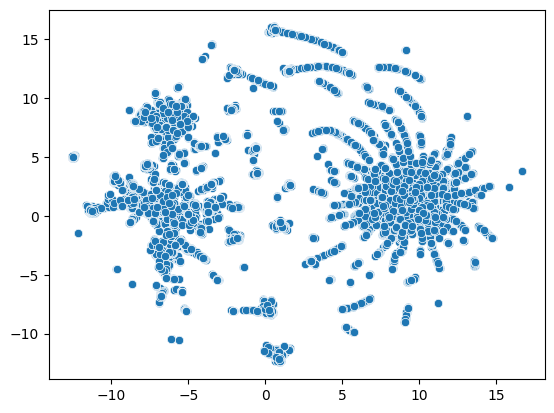

In [45]:
sns.scatterplot(x=data_normal_umap[:, 0], y=data_normal_umap[:, 1])

Выделяются три класса. Попробуем натравить Birch.

In [53]:
birch = sk_cluster.Birch()
pred_birch_umap = birch.fit_predict(data_normal_umap)

<Axes: >

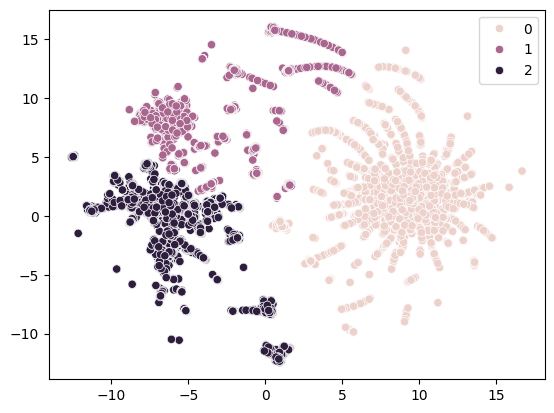

In [54]:
sns.scatterplot(x=data_normal_umap[:, 0], y=data_normal_umap[:, 1], hue=pred_birch_umap)

In [55]:
safe_pred(pred_birch_umap, 'submission_birch_normal_umap.csv')

Score: 0.07408 (так и не смог побить рекорд)

In [56]:
birch = sk_cluster.Birch(n_clusters=2)
pred_birch_umap = birch.fit_predict(data_normal_umap)

<Axes: >

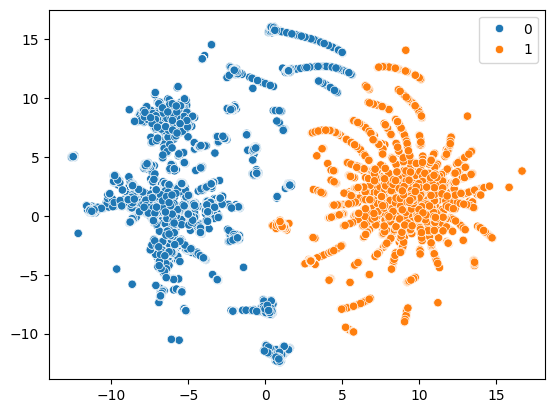

In [57]:
sns.scatterplot(x=data_normal_umap[:, 0], y=data_normal_umap[:, 1], hue=pred_birch_umap)

In [58]:
safe_pred(pred_birch_umap, 'submission_birch_normal_umap_2.csv')

Score: 0.03931 (ещё хуже)

In [65]:
umap_trans = umap.UMAP(n_components=20)

In [66]:
data_normal_umap_20 = umap_trans.fit_transform(data_sp_clean_normal_600d)

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [67]:
birch = sk_cluster.Birch(n_clusters=8)
pred_birch_umap_20 = birch.fit_predict(data_normal_umap_20)

<Axes: >

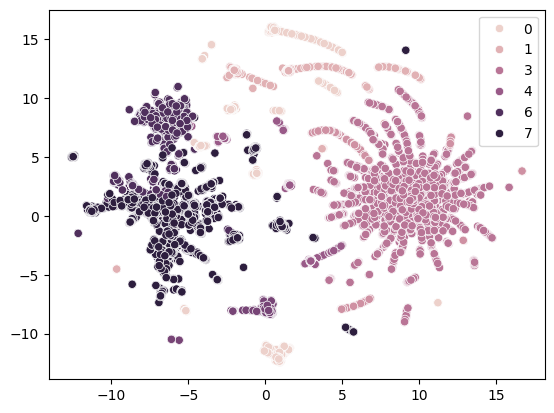

In [68]:
sns.scatterplot(x=data_normal_umap[:, 0], y=data_normal_umap[:, 1], hue=pred_birch_umap_20)

Смущают кометы.

# Краткие выводы

* Лучше всего себя показал Birch
* Пока достигнутые результаты не радуют.

Что ещё не пробовал:
* Метод локтя.
* Замена выбросов на более стандартные значения.
* Замерять silhouette.

# Начинаем всё сначала

## Загрузка данных

In [6]:
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.cluster as sk_cluster
import sklearn.preprocessing as sk_preproc
import sklearn.decomposition as sk_decomp

from sklearn import metrics
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [3]:
data = sparse.load_npz('train.npz')

In [3]:
data.shape

(21000, 3049)

In [4]:
def safe_pred(pred, filename):
    submission = pd.read_csv('sample_submission.csv', index_col='ID')
    submission['TARGET'] = pred
    submission.to_csv(filename)

## Предобработка

In [5]:
%%time
feat_uniq_count = defaultdict(list)
for i in range(data.shape[1]):
    column_data = np.array(data[:, i].todense())[:, 0]
    uniq = np.unique(column_data)
    count_uniq = len(uniq)
    feat_uniq_count[count_uniq].append(i)

CPU times: user 34.5 s, sys: 6.26 ms, total: 34.5 s
Wall time: 34.5 s


In [6]:
len(feat_uniq_count[1])

616

Удаляем константные признаки:

In [7]:
def inv_ind(len, ind) -> np.ndarray:
    res = np.arange(len)
    res = res[~np.isin(res, ind)]
    return res

data = data[:, inv_ind(data.shape[1], feat_uniq_count[1])]

In [8]:
data.shape

(21000, 2433)

Определяем столбы с выбросами по правилу трех сигм:

In [8]:
mean = np.array(np.mean(data.todense(), axis=0))
var = np.sqrt(np.array(np.var(data.todense(), axis=0)))

emissons = np.abs(data - mean) > (3 * var)

In [13]:
np.savetxt('emissons', emissons.sum(axis=0), fmt='%d')

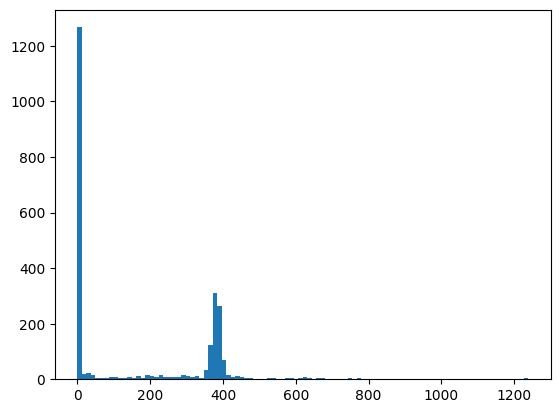

In [32]:
plt.hist(np.asarray(emissons.sum(axis=0))[0], bins=100)
plt.show()

Смущают несколько пиков. Попробуем взять 4 сигмы:

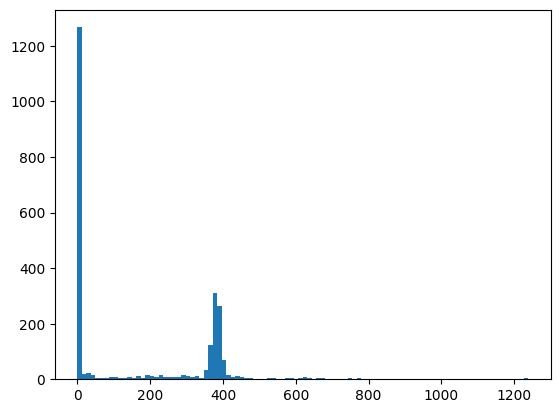

In [9]:
emissons = np.abs(data - mean) > (4 * var)
plt.hist(np.asarray(emissons.sum(axis=0))[0], bins=100)
plt.show()

Значительно лучше, так это значение и оставим.

In [10]:
data_emis = np.where((data - mean) > (4 * var), mean + 4 * var, data.todense())
data_emis = np.where((mean - data) > (4 * var), mean - 4 * var, data_emis)

Теперь будем искать очень маленькие значения.

In [42]:
(np.abs(data_emis) < 1e-8).sum()

np.int64(39418505)

In [44]:
39418505 / data_emis.size

0.7715050006850254

In [45]:
(np.abs(data_emis) == 0.0).sum()

np.int64(39388479)

In [46]:
39388479 / data_emis.size

0.7709173272268217

не очень сильно влияет.

Нормируем:

In [50]:
scaler = sk_preproc.RobustScaler()
data_emis_robust = scaler.fit_transform(data_emis)

## Кластеризуем

### Чистый K-means + метод локтя

[Источник](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)

In [59]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in tqdm(K):
    kmeanModel = sk_cluster.KMeans(n_clusters=k, random_state=42).fit(data_emis_robust)
    
    distortions.append(sum(np.min(cdist(data_emis_robust, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / data_emis_robust.shape[0])
    
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

100%|██████████| 19/19 [00:38<00:00,  2.04s/it]


Distortion values:
1 : 4913288677.113151
2 : 4550296015.701346
3 : 4143108871.834587
4 : 3923474879.6603765
5 : 3436091552.8320513
6 : 3318119781.100957
7 : 3192557535.472559
8 : 3139574984.212391
9 : 2981155166.263465
10 : 2890986668.7924333
11 : 2631926353.7085214
12 : 2490579905.4953904
13 : 2386249494.4672546
14 : 2294425861.0845733
15 : 2276180350.801759
16 : 2229404767.359979
17 : 2135084725.4498277
18 : 2074648000.0567806
19 : 2058228838.2677433


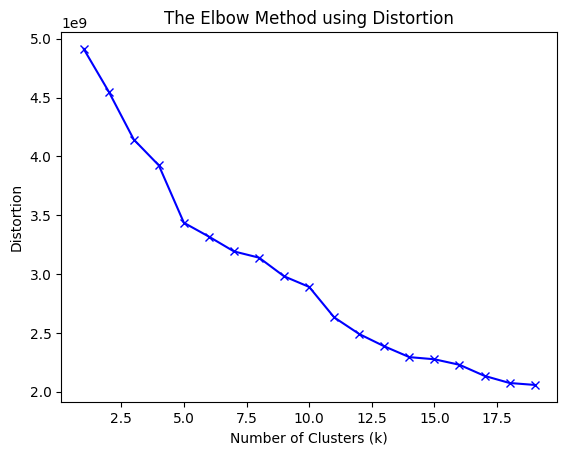

In [60]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Оптимальным выбором будет где-то 13 кластеров.

In [61]:
kmeans = sk_cluster.KMeans(n_clusters=13)
pred_kmeans = kmeans.fit_predict(data_emis_robust)

Попробуем визуализировать с помощью Umap:

In [62]:
import umap

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
umap_trans = umap.UMAP()

In [64]:
data_emis_robust_umap = umap_trans.fit_transform(data_emis_robust)

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: >

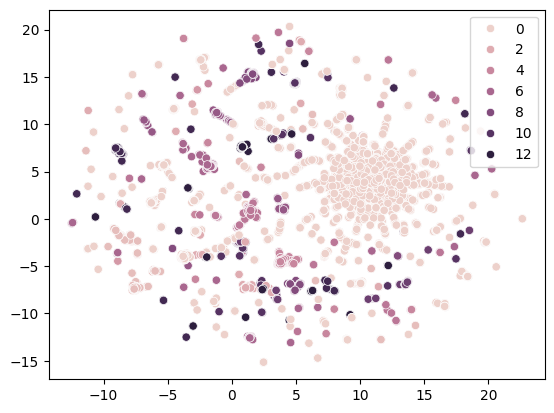

In [65]:
sns.scatterplot(x=data_emis_robust_umap[:, 0], y=data_emis_robust_umap[:, 1], hue=pred_kmeans)

In [66]:
silhouette_kmeans = metrics.silhouette_score(data_emis_robust, pred_kmeans)

In [67]:
silhouette_kmeans

np.float64(0.4951904867463922)

Попробуем отправить:

In [68]:
safe_pred(pred_kmeans, 'submission_emis_robust_kmeans.csv')

Score: 0.00784

Эм... Видимо это из-за того, что большинство элементов отнесены к нулевому классу.

Попробуем перейти в пространство меньшей размерности и применить Birch:

In [69]:
%%time
umap_trans = umap.UMAP(n_components=100)
data_emis_robust_umap_100d = umap_trans.fit_transform(data_emis_robust)

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 10min 38s, sys: 3.62 s, total: 10min 41s
Wall time: 45.6 s


Также попробуем сделать аналогично методу локтя, но для силуэта.

In [74]:
silhouette = []
mapping1 = {}
K = range(2, 20)

for k in tqdm(K):
    birchModel = sk_cluster.Birch(n_clusters=k)
    pred_birch = birchModel.fit_predict(data_emis_robust_umap_100d)
    
    silhouette.append(metrics.silhouette_score(data_emis_robust_umap_100d, pred_birch))
    
    mapping1[k] = silhouette[-1]

100%|██████████| 18/18 [02:11<00:00,  7.31s/it]


Silhouette values:
2 : 0.1679847538471222
3 : 0.1913382112979889
4 : 0.20864169299602509
5 : 0.22455435991287231
6 : 0.24068252742290497
7 : 0.24818621575832367
8 : 0.24674655497074127
9 : 0.2458103448152542
10 : 0.25792643427848816
11 : 0.26103028655052185
12 : 0.2621079385280609
13 : 0.2765600383281708
14 : 0.2823692262172699
15 : 0.28302130103111267
16 : 0.2898632884025574
17 : 0.29127731919288635
18 : 0.2980926036834717
19 : 0.26602765917778015


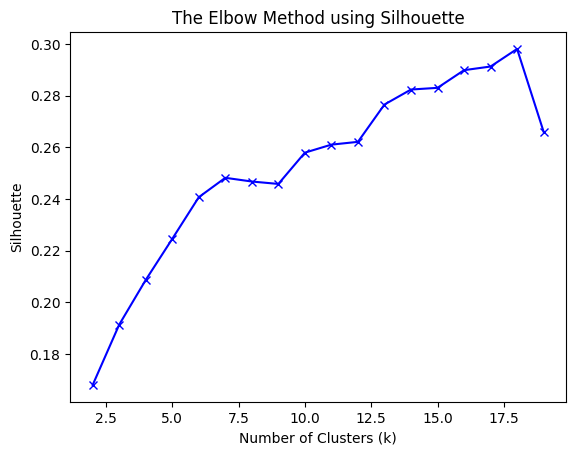

In [75]:
print("Silhouette values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, silhouette, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette')
plt.title('The Elbow Method using Silhouette')
plt.show()

Лучший результат при n = 18.

In [76]:
birch = sk_cluster.Birch(n_clusters=18)
pred_birch = birchModel.fit_predict(data_emis_robust_umap_100d)

<Axes: >

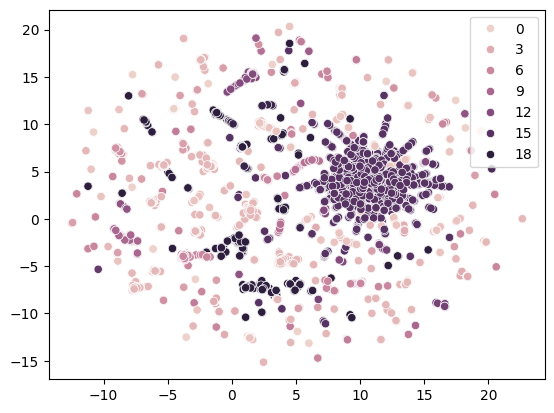

In [77]:
sns.scatterplot(x=data_emis_robust_umap[:, 0], y=data_emis_robust_umap[:, 1], hue=pred_birch)

Предположение: использование приведения к нормальному распределению некорректно, т.к. в нуле собирается большое количество точек, что могло быть не свойственно первоначальным данным. Нужно использовать другое шкалирование.

### Используем MinMaxScaler

In [11]:
scaler = sk_preproc.MinMaxScaler()
data_emis_mm = scaler.fit_transform(data_emis)

#### Снова K-means + метод локтя

In [12]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in tqdm(K):
    kmeanModel = sk_cluster.KMeans(n_clusters=k, random_state=42).fit(data_emis_mm)
    
    distortions.append(sum(np.min(cdist(data_emis_mm, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / data_emis_mm.shape[0])
    
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

100%|██████████| 19/19 [01:32<00:00,  4.88s/it]


Distortion values:
1 : 95.72347182091494
2 : 95.597856974377
3 : 95.47115237317841
4 : 95.396423949149
5 : 95.35022352018972
6 : 95.30536978321783
7 : 95.16476695464411
8 : 95.25806441304242
9 : 95.14630903227976
10 : 95.11057302780371
11 : 95.08232883929487
12 : 95.05563708857308
13 : 94.98232514460084
14 : 94.92771392652833
15 : 94.92497701464748
16 : 94.90000913257634
17 : 94.87066979990554
18 : 94.8544004412239
19 : 94.85903573702207


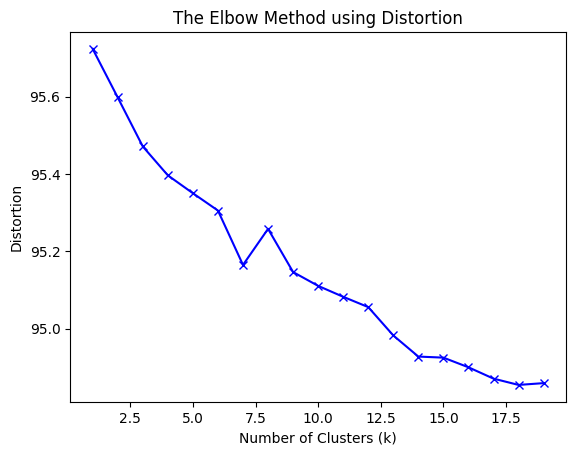

In [13]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Возьмем 13 кластеров.

In [14]:
kmeans = sk_cluster.KMeans(n_clusters=13, random_state=42)
pred_kmeans_mm = kmeans.fit_predict(data_emis_mm)

In [15]:
import umap

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
umap_trans = umap.UMAP()

In [17]:
%%time
data_emis_mm_umap = umap_trans.fit_transform(data_emis_mm)

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

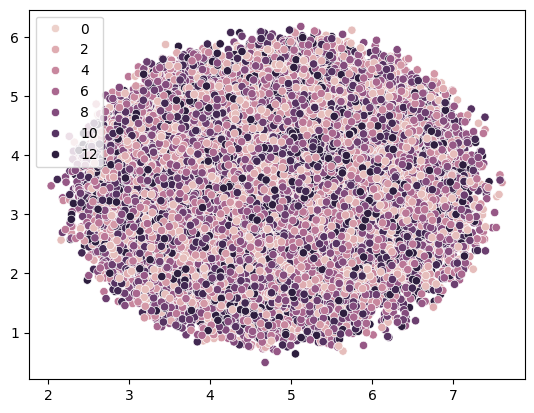

In [18]:
sns.scatterplot(x=data_emis_mm_umap[:, 0], y=data_emis_mm_umap[:, 1], hue=pred_kmeans_mm)

Не очень похоже на правду, попробуем Birch.

In [19]:
%%time
birch = sk_cluster.Birch(n_clusters=13)
pred_birch_mm = birch.fit_predict(data_emis_mm)

<Axes: >

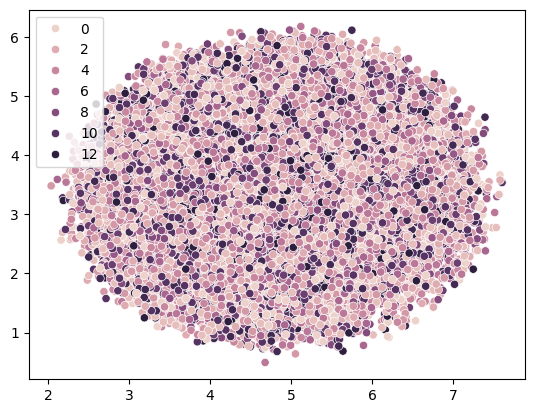

In [20]:
sns.scatterplot(x=data_emis_mm_umap[:, 0], y=data_emis_mm_umap[:, 1], hue=pred_birch_mm)

Аналогично, но попробуем.

In [21]:
safe_pred(pred_birch_mm, 'submission_emis_birch_mm.csv')

Score: 0.00505

Предположение: скейлеры всё портят.

In [22]:
umap_trans = umap.UMAP(n_components=100)

In [23]:
%%time
data_emis_mm_umap_100d = umap_trans.fit_transform(data_emis_mm)

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 4min 33s, sys: 1.9 s, total: 4min 35s
Wall time: 20.2 s


In [25]:
birch = sk_cluster.Birch(n_clusters=13)
pred_birch_mm_100 = birch.fit_predict(data_emis_mm_umap_100d)

<Axes: >

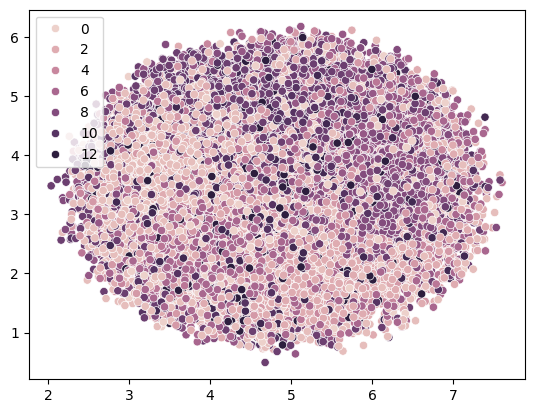

In [26]:
sns.scatterplot(x=data_emis_mm_umap[:, 0], y=data_emis_mm_umap[:, 1], hue=pred_birch_mm_100)

Вроде получше.

In [27]:
safe_pred(pred_birch_mm_100, 'submission_emis_birch_mm_100d.csv')